In [17]:
# import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import cv2
import math
import torch
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
import numpy as np
import matplotlib.colorbar as colorbar

import requests
from io import BytesIO
from PIL import Image
import numpy as np
from maskrcnn_benchmark.utils import cv2_util
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from moviepy.editor import VideoFileClip

# this makes our figures bigger
pylab.rcParams['figure.figsize'] = 20*1.5, 12*1.5

from maskrcnn_benchmark.config import cfg
from maskrcnn_benchmark.structures.keypoint import keypoints_to_heat_map
from maskrcnn_benchmark.modeling.roi_heads.keypoint_head.loss import project_keypoints_to_heatmap
from predictor import COCODemo

In [18]:
def load(img_path):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    pil_image = Image.open(img_path).convert("RGB")
    # convert to BGR format
    image = np.array(pil_image)[:, :, [2, 1, 0]]
    return image

def load_video(video_path,frame_id=[0]):
    """
    Given an url of an image, downloads the image and
    returns a PIL image
    """
    
    video_clip = VideoFileClip(video_path)
    if frame_id is None:
        nframes = int(video_clip.fps * video_clip.duration)
        frame_id = range(nframes)
    images = []
    for i in frame_id:
        image = video_clip.get_frame(i/video_clip.fps)
        # convert to BGR format
        image = np.array(image)[:, :, [2, 1, 0]]
        images += [image]
    video_clip.close()
    
    return images

def imshow(img):
    plt.gca().invert_yaxis()
    plt.imshow(img[:, :, [2, 1, 0]])
    plt.axis("off")
    
def sigmoid(x):
  return 1 / (1 + math.exp(-x))
# define vectorized sigmoid
sigmoid_v = np.vectorize(sigmoid)

# num keypoints per animal, heatmap
def calculate_peaks(numparts, heatmap_avg):
    score = np.ones((numparts,)) * 0.000001
    all_peaks = []
    peak_counter = 0
    if len(score) < numparts:
        score = score[:numparts]
        print("score", score)
        ##logger.ERROR(‘Not enough scores provided for number of parts’)
        # return
    # threshold_detection = params[‘thre1’]
    # tic_localmax=time.time()
    for part in range(numparts):
        map_ori = heatmap_avg[part, :, :]
        map = map_ori
        map_left = np.zeros(map.shape)
        map_left[1:, :] = map[:-1, :]
        map_right = np.zeros(map.shape)
        map_right[:-1, :] = map[1:, :]
        map_up = np.zeros(map.shape)
        map_up[:, 1:] = map[:, :-1]
        map_down = np.zeros(map.shape)
        map_down[:, :-1] = map[:, 1:]
        #peaks_binary = np.logical_and(np.logical_and(np.logical_and(map >= map_left, map >= map_right),
                                                     #np.logical_and(map >= map_up, map >= map_down)), map > score[part])
        peaks_binary = (sigmoid_v(map_ori) > .2)
        #print("pb shap", np.shape(peaks_binary))
        peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0]))  # note reverse
        peaks_with_score_and_id = [x + (map_ori[x[1], x[0]], i + peak_counter,) for i, x in
                                   enumerate(peaks)]  # if x[0]>0 and x[1]>0 ]
        all_peaks.append(peaks_with_score_and_id)
        peak_counter += len(peaks)
    return all_peaks



In [19]:
params = {
    'text.latex.preamble': ['\\usepackage{gensymb}'],
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'jet',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 10, # fontsize for x and y labels (was 10)
    'axes.titlesize': 12,
    'font.size': 12, # was 10
    'legend.fontsize': 10, # was 10
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    #'text.usetex': True,
    'figure.figsize': [20, 12],
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

In [20]:
def overlay_keypoints(image, predictions):
        #keypoints = predictions.get_field("keypoints")
        kps = predictions#keypoints.keypoints
        scores = kps.new_ones((kps.size(0), kps.size(1)))
        kps = torch.cat((kps[:, :, 0:2], scores[:, :, None]), dim=2).numpy()
        for region in kps:
            kfun = BeeKeypoints
            image = vis_keypoints_others(
                    image,
                    region.transpose((1, 0)),
                    kp_thresh=0,
                    kfun=kfun)
                
        return image


In [21]:
import cv2
import torch
from torchvision import transforms as T

from maskrcnn_benchmark.modeling.detector import build_detection_model
from maskrcnn_benchmark.utils.checkpoint import DetectronCheckpointer
from maskrcnn_benchmark.structures.image_list import to_image_list
from maskrcnn_benchmark.modeling.roi_heads.mask_head.inference import Masker
from maskrcnn_benchmark import layers as L
from maskrcnn_benchmark.utils import cv2_util

import numpy as np
import matplotlib.pyplot as plt
from maskrcnn_benchmark.structures.keypoint import PersonKeypoints, BeeKeypoints, FlyKeypoints


def vis_keypoints_others(img, kps, kp_thresh=2, alpha=0.7, kfun=PersonKeypoints):
    """Visualizes keypoints (adapted from vis_one_image).
    kps has shape (4, #keypoints) where 4 rows are (x, y, logit, prob).
    """
    img = img.copy()
    dataset_keypoints = kfun.NAMES
    kp_lines = kfun.CONNECTIONS

    # Convert from plt 0-1 RGBA colors to 0-255 BGR colors for opencv.
    cmap = plt.get_cmap('rainbow')
    colors = [cmap(i) for i in np.linspace(0, 1, len(kp_lines) + 2)]
    colors = [(c[2] * 255, c[1] * 255, c[0] * 255) for c in colors]

    # Perform the drawing on a copy of the image, to allow for blending.
    kp_mask = np.copy(img)
    
    # Draw the keypoints.
    for l in [0]:#range(len(kp_lines)):
        i1 = kp_lines[l][0]
        i2 = kp_lines[l][1]
        p1 = kps[0, i1], kps[1, i1]
        p2 = kps[0, i2], kps[1, i2]
        #if kps[2, i1] > kp_thresh and kps[2, i2] > kp_thresh:
         #   cv2.line(
          #      kp_mask, p1, p2,
           #     color=colors[l], thickness=2, lineType=cv2.LINE_AA)
        if kps[2, i1] > kp_thresh:
            cv2.circle(
                kp_mask, p1,
                radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)
        #if kps[2, i2] > kp_thresh:
         #   cv2.circle(
          #      kp_mask, p2,
           #     radius=16, color=colors[l], thickness=-1, lineType=cv2.LINE_AA)

    # Blend the keypoints.
    return cv2.addWeighted(img, 1.0 - alpha, kp_mask, alpha, 0)

def bounding_box(points):
    x_coordinates, y_coordinates = zip(*points)
    return [min(x_coordinates), min(y_coordinates), max(x_coordinates), max(y_coordinates)]

def get_centroid(coord):
    return [(coord[0]+coord[2])/2, (coord[1]+coord[3])/2]

def get_dist(p1, p2):
    dist = math.hypot(p2[0] - p1[0], p2[1] - p1[1])
    return dist


In [22]:
#test_file = 'bee_test.png'
#image = load(test_file)
base = "../tools/datasets/bee/validation/"
#base = "../tools/datasets/bee/train/"
base_val = "../tools/datasets/bee/annotations/validation.json"
#base_val = "../tools/datasets/bee/annotations/train_bee_annotations2018_nondup.json"

import json
with open(base_val) as f:
    data_an = json.load(f)
#print(data_an["annotations"][0])

test_files = []
for p in data_an['images'][:]:
    test_files.append(str(p['file_name']))

print(test_files)
print(len(test_files))
test_images = []
for file in test_files:
    test_images.append(load(base + file))



['000000051501.jpg', '000000051602.jpg', '000000051656.jpg', '000000051770.jpg', '000000052209.jpg', '000000052239.jpg', '000000052248.jpg', '000000052271.jpg', '000000052328.jpg', '000000052361.jpg', '000000052413.jpg', '000000052563.jpg', '000000052583.jpg', '000000052587.jpg', '000000052738.jpg', '000000052799.jpg', '000000052861.jpg', '000000053184.jpg', '000000053247.jpg', '000000053341.jpg', '000000053573.jpg', '000000053614.jpg', '000000053776.jpg', '000000053802.jpg', '000000053827.jpg', '000000053842.jpg', '000000053857.jpg', '000000053866.jpg', '000000053890.jpg', '000000053916.jpg']
30


In [30]:
#MSE sleap
import h5py
filename = '../tools/sleap_bottomup.slp'
with h5py.File(filename, 'r') as f:
    # List all groups
    #print('Keys: %s' % f.keys())
    a_group_key = list(f.keys())
    #print('a_group_key:', a_group_key)
    # Get the data
    frames = f['frames'][()]
    instances = f['instances'][()]
    points = f['points'][()]
    pred_points = f['pred_points'][()]


for p in instances:
    print(p)


(0, 1, 0, 0, -1, -1, 6.1212597, 0, 5)
(1, 1, 0, 0, -1, -1, 1.6559818, 5, 10)
(2, 1, 0, 0, -1, -1, 7.1491723, 10, 15)
(3, 1, 0, 0, -1, -1, 1.9502741, 15, 20)
(4, 1, 0, 0, -1, -1, 6.208929, 20, 25)
(5, 1, 0, 0, -1, -1, 7.1131315, 25, 30)
(6, 1, 0, 0, -1, -1, 5.893938, 30, 35)
(7, 1, 0, 0, -1, -1, 7.2472816, 35, 40)
(8, 1, 0, 0, -1, -1, 7.08401, 40, 45)
(9, 1, 0, 0, -1, -1, 2.9198895, 45, 50)
(10, 1, 0, 0, -1, -1, 8.470883, 50, 55)
(11, 1, 0, 0, -1, -1, 7.69057, 55, 60)
(12, 1, 0, 0, -1, -1, 6.7568345, 60, 65)
(13, 1, 0, 0, -1, -1, 7.240335, 65, 70)
(14, 1, 0, 0, -1, -1, 7.548971, 70, 75)
(15, 1, 0, 0, -1, -1, 6.8147883, 75, 80)
(16, 1, 0, 0, -1, -1, 0.69587964, 80, 85)
(17, 1, 0, 0, -1, -1, 6.3895254, 85, 90)
(18, 1, 0, 0, -1, -1, 7.259707, 90, 95)
(19, 1, 0, 0, -1, -1, 1.7608553, 95, 100)
(20, 1, 1, 0, -1, -1, 4.1390576, 100, 105)
(21, 1, 1, 0, -1, -1, 7.119459, 105, 110)
(22, 1, 1, 0, -1, -1, 6.8050003, 110, 115)
(23, 1, 1, 0, -1, -1, 3.7289116, 115, 120)
(24, 1, 1, 0, -1, -1, 7.625293

(353, 1, 22, 0, -1, -1, 7.2215796, 1765, 1770)
(354, 1, 22, 0, -1, -1, 1.7390028, 1770, 1775)
(355, 1, 22, 0, -1, -1, 1.1208501, 1775, 1780)
(356, 1, 22, 0, -1, -1, 6.3022385, 1780, 1785)
(357, 1, 22, 0, -1, -1, 5.177369, 1785, 1790)
(358, 1, 23, 0, -1, -1, 7.631801, 1790, 1795)
(359, 1, 23, 0, -1, -1, 6.8545775, 1795, 1800)
(360, 1, 23, 0, -1, -1, 1.6417599, 1800, 1805)
(361, 1, 23, 0, -1, -1, 7.047724, 1805, 1810)
(362, 1, 23, 0, -1, -1, 7.2757936, 1810, 1815)
(363, 1, 23, 0, -1, -1, 6.9573793, 1815, 1820)
(364, 1, 23, 0, -1, -1, 4.5283318, 1820, 1825)
(365, 1, 23, 0, -1, -1, 7.441043, 1825, 1830)
(366, 1, 23, 0, -1, -1, 7.6419425, 1830, 1835)
(367, 1, 23, 0, -1, -1, 7.4417605, 1835, 1840)
(368, 1, 23, 0, -1, -1, 7.62955, 1840, 1845)
(369, 1, 23, 0, -1, -1, 7.909589, 1845, 1850)
(370, 1, 23, 0, -1, -1, 7.637204, 1850, 1855)
(371, 1, 23, 0, -1, -1, 6.282478, 1855, 1860)
(372, 1, 23, 0, -1, -1, 4.4055176, 1860, 1865)
(373, 1, 24, 0, -1, -1, 2.067489, 1865, 1870)
(374, 1, 24, 0, -1, -1,

In [24]:
kps_bu = []#np.zeros((30))
for img_idx in range(0,30):
    if img_idx == 0:
        num_before = 0
        num_bees_per_img = frames[0][4]
    else:
        num_before = frames[(img_idx-1)][4]
        num_bees_per_img = frames[img_idx][4]-frames[img_idx][3]
    print("nb", num_before)
    print("num kps", int(num_bees_per_img*5))
    print("range", int(num_before*5+num_bees_per_img*5) - int(num_before*5))
    #kps[img_idx] = np.zeros((num_bees_per_img,5,2))
    kps_bu.append(np.zeros((num_bees_per_img,5,2)))
    counter = 0
    current_idx = int(num_before*5)
    for pred_bee in range(0,num_bees_per_img):
        for kpt in range(0,5):
    #for point in pred_points[int(num_before*5):int(num_before*5+num_bees_per_img*5)]:
            #print("point", point)
            x = pred_points[current_idx][0]
            y = pred_points[current_idx][1]
            kps_bu[img_idx][pred_bee][kpt][0] = x
            kps_bu[img_idx][pred_bee][kpt][1] = y
            current_idx = current_idx + 1
        #while
#print("KPSSSS",kps_bu)


bboxes_bu = []

bees_in_imgs = []
for img_idx in range(0,30):
    if img_idx == 0:
        num_bees_per_img = frames[0][4]
        bees_in_imgs.append(num_bees_per_img)
    else:
        num_bees_per_img = frames[img_idx][4]-frames[img_idx][3]
        bees_in_imgs.append(num_bees_per_img)

for im_idx in range(0,30):
    bb_in_im = np.zeros((bees_in_imgs[im_idx],4))
    for bee in range(0, bees_in_imgs[im_idx]):
        bb_i = bounding_box(kps_bu[im_idx][bee])
        bb_in_im[bee] = bb_i
        #print("kps: ", kps_bu[im_idx][bee])
        #print("box: ", bb_i)
    bboxes_bu.append(bb_in_im)
    
print("BBOXESS: ",bboxes_bu)

nb 0
num kps 105
range 105
nb 21
num kps 70
range 70
nb 35
num kps 50
range 50
nb 45
num kps 60
range 60
nb 57
num kps 55
range 55
nb 68
num kps 50
range 50
nb 78
num kps 70
range 70
nb 92
num kps 85
range 85
nb 109
num kps 85
range 85
nb 126
num kps 75
range 75
nb 141
num kps 50
range 50
nb 151
num kps 50
range 50
nb 161
num kps 80
range 80
nb 177
num kps 65
range 65
nb 190
num kps 110
range 110
nb 212
num kps 90
range 90
nb 230
num kps 100
range 100
nb 250
num kps 80
range 80
nb 266
num kps 80
range 80
nb 282
num kps 55
range 55
nb 293
num kps 85
range 85
nb 310
num kps 95
range 95
nb 329
num kps 80
range 80
nb 345
num kps 65
range 65
nb 358
num kps 90
range 90
nb 376
num kps 100
range 100
nb 396
num kps 90
range 90
nb 414
num kps 80
range 80
nb 430
num kps 70
range 70
nb 444
num kps 50
range 50
BBOXESS:  [array([[ 780.84759521,   18.76969147,  874.33813477,  119.15652466],
       [ 950.36358643,   24.93842506, 1008.75592041,   26.1102829 ],
       [1249.74816895,   85.22297668, 1524

In [42]:
print("KPS !!", kps_bu[11])

KPS !! [[[1357.23669434   62.67543411]
  [1369.65063477   98.62140656]
  [1393.06140137   14.62785244]
  [          nan           nan]
  [          nan           nan]]

 [[1178.40905762  -46.32356644]
  [1178.50109863  193.53616333]
  [1178.38903809   86.04069519]
  [1142.53210449  229.6275177 ]
  [1202.27587891  206.25422668]]

 [[ 228.88000488  -34.41603088]
  [ 205.5124054   145.77064514]
  [ 240.63044739   85.27181244]
  [ 193.30725098  145.59761047]
  [ 241.18821716  181.5308075 ]]

 [[ 481.34341431  181.48057556]
  [ 289.48028564  253.09501648]
  [ 397.50704956  217.18490601]
  [ 265.33605957  229.59033203]
  [ 289.31848145  277.64782715]]

 [[1237.45825195  290.5697937 ]
  [1477.75427246  242.55613708]
  [1393.9753418   254.42765808]
  [1502.20092773  278.70819092]
  [1502.22058105  206.34121704]]

 [[2210.18359375  325.82595825]
  [2258.12060547  373.11312866]
  [2223.03857422  253.41899109]
  [2258.13378906  110.04924774]
  [2234.203125     97.27648926]]

 [[ 481.73999023  481

In [39]:
#single mse sleap bu
import matplotlib.gridspec as gridspec
from itertools import chain
import pdb


loss = "bottom_up"

mse_total = []
tim = [test_images[0]]
for idx, image in enumerate(test_images):
#     if idx == 0:
#         num_bees_per_img = frames[0][4]
#     else:
#         num_bees_per_img = frames[idx][4]-frames[idx][3]
#     print("num_bees_in_img",num_bees_per_img)
    mse_per_bee = []
    kps = kps_bu[idx]
    bboxes = bboxes_bu[idx]
    
    #kps = tps.get_field("keypoints").keypoints
    #bboxes = tps.bbox
    #print(bbox)
    #print(kps)

    
    for p in data_an['images'][:]:
        if (str(p['file_name']) == test_files[idx] ):
            im_id = p['id']         
    print(im_id)
    for p in data_an['annotations'][:]:
        if ((p['image_id']) == im_id ):
            #print(p['id'])
            #bb = p["segmentation"]#p['bbox']
            bb = p['bbox']
            #bb = bb[0]
            print('bb', bb)
            bb_f = [bb[:2], bb[2:4], bb[4:6], bb[6:]]
            print('bbf', bb_f)
            bbox = bounding_box(bb_f)
            cent_val = get_centroid(bbox)
            dists = []
            #print(cent_val)
            for index, p_bbox in enumerate(bboxes):
                if np.isnan(p_bbox).any() == False:
                    print("NOT NANNNNNN", p_bbox)
                    cp = get_centroid(p_bbox)
                    dist = get_dist(cent_val, cp)
                    dists.append(dist)
                else:
                    dists.append(9999999)
                #print(dist)
            min_idx = dists.index(min(dists))
            #print("min id", min_idx)
            kps_val = p["keypoints"]
            print('kps val', kps_val)
            # comment for test and remove og
            #kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
            #print('kps val', kps_val)
            kps_pred = kps[min_idx].tolist()
            kps_pred_list = [kps_pred[0],kps_pred[1],kps_pred[2],kps_pred[3],kps_pred[4]]
            kps_pl = list(chain.from_iterable(kps_pred_list))
            #print("kps val", kps_val)
            print("kp pred", kps_pred)
            print("kp pred listt", kps_pred_list)
            diff_vec = np.array(kps_val) - np.array(kps_pl)
            diff_vec = np.array([0 if math.isnan(x) else x for x in diff_vec])
            #print(diff_vec)
            #print(diff_vec*diff_vec)
            diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
            #print(diff_vec_sum_sq)
            if np.isnan(diff_vec_sum_sq):
                print("nan alert", diff_vec_sum_sq)
                print("diff_vec", diff_vec)
                print("kp pred listt", kps_pred_list)
                print('kps val', kps_val)
                pdb.set_trace()
            mse_per_bee.append(diff_vec_sum_sq)
        
    mse_per_image = sum(mse_per_bee)
    
        
    #print("mse", mse_per_image)
    #print("mse", mse_per_bee)
    mse_final = mse_per_image/len(mse_per_bee)
    mse_total.append(mse_final)
    #print("mse final", mse_final)
 

    #img3 = predictions[:, :, [2, 1, 0]]
    #b,g,r = cv2.split(img3)       # get b,g,r
    #img3 = cv2.merge([r,g,b])     # switch it to rgb
    #im = axes[idx][2].imshow(img3)
    #axes[idx][2].invert_yaxis()
    #plt.savefig(base_file + '_reg.png')
print("mse total for all images", mse_total)
print(sum(mse_total))
mse_test = sum(mse_total)/len(mse_total)
print("mse yo sleap bu", mse_test)


51501
bb [625.7417691078837, 229.806445285851, 462.65927639188794, 518.0452696210994, 614.1000838512198, 603.7288843678266, 772.2582308921163, 324.193554714149]
bbf [[625.7417691078837, 229.806445285851], [462.65927639188794, 518.0452696210994], [614.1000838512198, 603.7288843678266], [772.2582308921163, 324.193554714149]]
NOT NANNNNNN [612.83050537  37.72294617 649.53546143 158.72293091]
NOT NANNNNNN [759.45404053  13.4772377  877.77758789 206.45657349]
NOT NANNNNNN [1238.48291016   97.30770874 1526.15783691  218.02992249]
NOT NANNNNNN [1850.40527344   37.95035172 1922.47045898  325.71817017]
NOT NANNNNNN [2209.54003906   85.18723297 2281.16601562  385.67407227]
NOT NANNNNNN [ 817.94067383  217.56263733 1118.20080566  313.74121094]
NOT NANNNNNN [1490.80151367  277.66925049 1754.66210938  541.98168945]
NOT NANNNNNN [506.43612671 277.9057312  698.37976074 565.95196533]
NOT NANNNNNN [1561.9185791   530.01080322 1658.07580566  865.69958496]
NOT NANNNNNN [517.41162109 588.98394775 589.2862

NOT NANNNNNN [612.83050537  37.72294617 649.53546143 158.72293091]
NOT NANNNNNN [759.45404053  13.4772377  877.77758789 206.45657349]
NOT NANNNNNN [1238.48291016   97.30770874 1526.15783691  218.02992249]
NOT NANNNNNN [1850.40527344   37.95035172 1922.47045898  325.71817017]
NOT NANNNNNN [2209.54003906   85.18723297 2281.16601562  385.67407227]
NOT NANNNNNN [ 817.94067383  217.56263733 1118.20080566  313.74121094]
NOT NANNNNNN [1490.80151367  277.66925049 1754.66210938  541.98168945]
NOT NANNNNNN [506.43612671 277.9057312  698.37976074 565.95196533]
NOT NANNNNNN [1561.9185791   530.01080322 1658.07580566  865.69958496]
NOT NANNNNNN [517.41162109 588.98394775 589.28625488 805.81884766]
NOT NANNNNNN [698.4901123  613.78887939 746.40466309 865.57495117]
NOT NANNNNNN [1154.55517578  661.7321167  1202.31774902  949.50646973]
NOT NANNNNNN [ 530.10455322  780.92401123  601.82019043 1034.24926758]
NOT NANNNNNN [ 349.27227783  878.49188232  457.45321655 1142.14562988]
NOT NANNNNNN [ 650.6007080

NOT NANNNNNN [1777.7109375   385.26394653 1861.86572266  685.77532959]
NOT NANNNNNN [1538.3848877   517.87030029 1622.54223633  841.35473633]
NOT NANNNNNN [ 745.8961792   637.98175049 1058.17749023  733.60241699]
NOT NANNNNNN [254.12261963 746.34191895 493.82067871 794.04669189]
NOT NANNNNNN [1321.68725586  710.07104492 1417.71862793 1022.50726318]
NOT NANNNNNN [ 313.90423584  937.59204102  494.03076172 1068.72912598]
NOT NANNNNNN [1166.74804688 1117.67578125 1358.78112793 1237.97485352]
kps val [1381, 1022, 1367, 773, 1386, 870, 1389, 734, 1315, 731]
kp pred [[1369.845458984375, 1022.5072631835938], [1369.7432861328125, 747.1276245117188], [1369.6802978515625, 830.1923217773438], [1417.7186279296875, 721.9305419921875], [1321.687255859375, 710.071044921875]]
kp pred listt [[1369.845458984375, 1022.5072631835938], [1369.7432861328125, 747.1276245117188], [1369.6802978515625, 830.1923217773438], [1417.7186279296875, 721.9305419921875], [1321.687255859375, 710.071044921875]]
bb [1089.175

NOT NANNNNNN [1777.7109375   385.26394653 1861.86572266  685.77532959]
NOT NANNNNNN [1538.3848877   517.87030029 1622.54223633  841.35473633]
NOT NANNNNNN [ 745.8961792   637.98175049 1058.17749023  733.60241699]
NOT NANNNNNN [254.12261963 746.34191895 493.82067871 794.04669189]
NOT NANNNNNN [1321.68725586  710.07104492 1417.71862793 1022.50726318]
NOT NANNNNNN [ 313.90423584  937.59204102  494.03076172 1068.72912598]
NOT NANNNNNN [1166.74804688 1117.67578125 1358.78112793 1237.97485352]
kps val [516, 821, 249, 784, 339, 777, 233, 832, 201, 726]
kp pred [[493.8206787109375, 794.0466918945312], [277.40130615234375, 758.487548828125], [385.39849853515625, 769.8978271484375], [265.279296875, 746.3419189453125], [254.12261962890625, 793.6788940429688]]
kp pred listt [[493.8206787109375, 794.0466918945312], [277.40130615234375, 758.487548828125], [385.39849853515625, 769.8978271484375], [265.279296875, 746.3419189453125], [254.12261962890625, 793.6788940429688]]
bb [212.87869577172552, 964.

NOT NANNNNNN [2186.01757812  193.28314209 2258.55688477  421.78512573]
NOT NANNNNNN [529.90661621 265.98046875 601.50146484 530.62335205]
NOT NANNNNNN [877.27990723 301.61489868 973.59588623 541.95507812]
NOT NANNNNNN [1045.25427246  361.49465942 1129.68444824  649.86187744]
NOT NANNNNNN [1561.59765625  445.4102478  1646.11975098  770.39215088]
NOT NANNNNNN [865.69897461 518.125      985.72662354 829.3203125 ]
NOT NANNNNNN [1298.06958008  554.25946045 1502.30847168  877.65325928]
NOT NANNNNNN [1790.53320312  614.50396729 1898.11425781  937.76501465]
NOT NANNNNNN [ 566.1953125   949.73956299  697.80688477 1202.01623535]
kps val [2249, 390, 2217, 139, 2232, 222, 2281, 139, 2260, 136]
kp pred [[2186.017578125, 193.28314208984375], [2258.386962890625, 397.3204650878906], [2234.442626953125, 312.8416748046875], [2234.744384765625, 421.7851257324219], [2258.556884765625, 409.5736083984375]]
kp pred listt [[2186.017578125, 193.28314208984375], [2258.386962890625, 397.3204650878906], [2234.442

NOT NANNNNNN [877.27990723 301.61489868 973.59588623 541.95507812]
NOT NANNNNNN [1045.25427246  361.49465942 1129.68444824  649.86187744]
NOT NANNNNNN [1561.59765625  445.4102478  1646.11975098  770.39215088]
NOT NANNNNNN [865.69897461 518.125      985.72662354 829.3203125 ]
NOT NANNNNNN [1298.06958008  554.25946045 1502.30847168  877.65325928]
NOT NANNNNNN [1790.53320312  614.50396729 1898.11425781  937.76501465]
NOT NANNNNNN [ 566.1953125   949.73956299  697.80688477 1202.01623535]
kps val [591, 537, 561, 295, 551, 380, 636, 279, 556, 233]
kp pred [[577.3240966796875, 530.6233520507812], [565.4566650390625, 289.9234313964844], [554.186279296875, 374.06011962890625], [601.50146484375, 265.9837341308594], [529.9066162109375, 265.98046875]]
kp pred listt [[577.3240966796875, 530.6233520507812], [565.4566650390625, 289.9234313964844], [554.186279296875, 374.06011962890625], [601.50146484375, 265.9837341308594], [529.9066162109375, 265.98046875]]
bb [377.1641844102496, 73.8662662758124, 2

NOT NANNNNNN [253.17497253 181.50135803 289.50888062 372.76412964]
NOT NANNNNNN [1082.66894531  289.97622681 1262.578125    577.32507324]
NOT NANNNNNN [385.37255859 302.01400757 433.81643677 553.64727783]
NOT NANNNNNN [1838.2989502   277.44033813 1922.59777832  589.324646  ]
NOT NANNNNNN [1598.0559082   445.57919312 1670.30566406  769.01922607]
NOT NANNNNNN [565.39764404 457.54211426 673.12609863 769.31982422]
NOT NANNNNNN [1118.42834473  602.58276367 1453.49438477  698.80609131]
NOT NANNNNNN [769.29016113 518.4107666  853.69073486 830.1595459 ]
NOT NANNNNNN [409.69604492 782.5534668  697.90820312 914.35791016]
NOT NANNNNNN [1501.6875      806.2387085  1585.46337891 1094.40429688]
NOT NANNNNNN [ 289.41900635  865.43994141  493.87716675 1105.40148926]
kps val [763, 505, 826, 786, 807, 701, 883, 842, 770, 832]
kp pred [[769.6849365234375, 518.4107666015625], [805.7288208007812, 793.1858520507812], [793.9528198242188, 721.4990234375], [769.2901611328125, 830.1595458984375], [853.690734863

NOT NANNNNNN [ 852.97039795  925.69830322 1093.42724609 1129.01416016]
kps val [1608, 763, 1654, 480, 1647, 568, 1683, 454, 1637, 450]
kp pred [[1609.966064453125, 758.274169921875], [1646.570556640625, 470.5000915527344], [1646.1007080078125, 542.198974609375], [1682.931884765625, 434.32470703125], [1598.533203125, 422.2306823730469]]
kp pred listt [[1609.966064453125, 758.274169921875], [1646.570556640625, 470.5000915527344], [1646.1007080078125, 542.198974609375], [1682.931884765625, 434.32470703125], [1598.533203125, 422.2306823730469]]
bb [1755.7041724144624, 1065.5220237314438, 1936.6376759697941, 868.4543224068468, 1808.4662350089714, 750.7764497118226, 1634.2958275855376, 940.4779762685562]
bbf [[1755.7041724144624, 1065.5220237314438], [1936.6376759697941, 868.4543224068468], [1808.4662350089714, 750.7764497118226], [1634.2958275855376, 940.4779762685562]]
NOT NANNNNNN [2186.24853516   13.20197392 2281.96826172  313.16940308]
NOT NANNNNNN [1646.19262695  133.44845581 1730.3366

NOT NANNNNNN [2187.36938477   25.81099319 2271.09399414  349.34411621]
NOT NANNNNNN [1441.41333008  181.97238159 1550.28405762  481.40484619]
NOT NANNNNNN [408.78674316 205.51211548 480.68981934 482.72418213]
NOT NANNNNNN [674.612854   325.85931396 865.89733887 433.6751709 ]
NOT NANNNNNN [1598.53137207  409.3911438  1694.81677246  745.28869629]
NOT NANNNNNN [626.4005127  469.81680298 842.32440186 698.52770996]
NOT NANNNNNN [1753.99121094  589.57519531 1898.4942627   829.7512207 ]
NOT NANNNNNN [ 721.89654541  853.83789062  841.85546875 1141.69506836]
NOT NANNNNNN [ 385.77862549 1070.27587891  469.66192627 1310.09191895]
kps val [847, 1139, 770, 893, 784, 966, 812, 846, 734, 847]
kp pred [[841.85546875, 1141.695068359375], [769.9021606445312, 901.6494140625], [793.2681274414062, 974.2365112304688], [805.6375122070312, 853.837890625], [721.8965454101562, 877.6068725585938]]
kp pred listt [[841.85546875, 1141.695068359375], [769.9021606445312, 901.6494140625], [793.2681274414062, 974.23651

NOT NANNNNNN [1598.53137207  409.3911438  1694.81677246  745.28869629]
NOT NANNNNNN [626.4005127  469.81680298 842.32440186 698.52770996]
NOT NANNNNNN [1753.99121094  589.57519531 1898.4942627   829.7512207 ]
NOT NANNNNNN [ 721.89654541  853.83789062  841.85546875 1141.69506836]
NOT NANNNNNN [ 385.77862549 1070.27587891  469.66192627 1310.09191895]
kps val [2263, 358, 2226, 101, 2242, 184, 2279, 69, 2249, 71]
kp pred [[2234.3515625, 349.3441162109375], [2234.75146484375, 73.45260620117188], [2233.70849609375, 168.83509826660156], [2271.093994140625, 49.165122985839844], [2187.369384765625, 25.810993194580078]]
kp pred listt [[2234.3515625, 349.3441162109375], [2234.75146484375, 73.45260620117188], [2233.70849609375, 168.83509826660156], [2271.093994140625, 49.165122985839844], [2187.369384765625, 25.810993194580078]]
52738
bb [1431.9027823524607, 648.5264832277304, 1392.0962551853538, 348.16814187592445, 1219.6045038474983, 371.02849446286916, 1258.0972176475393, 661.4735167722696]
bbf

NOT NANNNNNN [398.81698608 686.21606445 602.62359619 769.99200439]
NOT NANNNNNN [ 998.09814453  577.48297119 1165.68969727  865.91906738]
NOT NANNNNNN [ 313.32131958  829.74981689  361.75909424 1069.51599121]
NOT NANNNNNN [ 817.88671875 1046.52429199  901.77001953 1273.50097656]
kps val [258, 869, 445, 982, 399, 918, 470, 1022, 438, 1054]
kp pred [[326.1206970214844, 1069.5159912109375], [313.3213195800781, 830.0064697265625], [361.75909423828125, 902.1567993164062], [338.18524169921875, 829.7498168945312], [337.4642028808594, 830.3775634765625]]
kp pred listt [[326.1206970214844, 1069.5159912109375], [313.3213195800781, 830.0064697265625], [361.75909423828125, 902.1567993164062], [338.18524169921875, 829.7498168945312], [337.4642028808594, 830.3775634765625]]
bb [194.972636314118, 542.4986631219982, 227.0800303703151, 835.7461955019317, 400.04637150288596, 816.8082749399713, 369.027363685882, 533.5013368780018]
bbf [[194.972636314118, 542.4986631219982], [227.0800303703151, 835.746195

NOT NANNNNNN [2042.1595459  409.3001709 2114.5625     697.5135498]
NOT NANNNNNN [1597.34741211  469.48748779 1753.85290527  781.43041992]
NOT NANNNNNN [746.13787842 494.03775024 819.00128174 794.69610596]
NOT NANNNNNN [264.16104126 541.16564941 312.76083374 770.31640625]
NOT NANNNNNN [1825.3692627   506.47463989 1933.52575684  841.76104736]
NOT NANNNNNN [398.81698608 686.21606445 602.62359619 769.99200439]
NOT NANNNNNN [ 998.09814453  577.48297119 1165.68969727  865.91906738]
NOT NANNNNNN [ 313.32131958  829.74981689  361.75909424 1069.51599121]
NOT NANNNNNN [ 817.88671875 1046.52429199  901.77001953 1273.50097656]
kps val [1589, 784, 1713, 516, 1683, 590, 1766, 482, 1656, 482]
kp pred [[1597.347412109375, 781.430419921875], [1706.23583984375, 517.5088500976562], [1670.288818359375, 577.8330688476562], [1753.8529052734375, 493.7337646484375], [1681.692626953125, 469.48748779296875]]
kp pred listt [[1597.347412109375, 781.430419921875], [1706.23583984375, 517.5088500976562], [1670.28881

NOT NANNNNNN [361.82495117 337.8420105  505.8500061  638.11102295]
NOT NANNNNNN [1621.53222656  397.61758423 1753.63928223  734.41113281]
NOT NANNNNNN [626.02862549 637.53723145 722.10028076 889.30718994]
NOT NANNNNNN [ 961.4196167   577.75512695 1069.38867188  890.13275146]
NOT NANNNNNN [1178.35229492  770.24981689 1310.19030762 1057.82751465]
NOT NANNNNNN [1417.65734863  745.67297363 1513.86572266 1045.35644531]
NOT NANNNNNN [ 553.89440918  925.92053223  626.62213135 1201.65637207]
NOT NANNNNNN [ 289.64147949 1021.54101562  349.15576172 1117.94104004]
NOT NANNNNNN [1165.67700195 1093.28063965 1298.58947754 1225.56445312]
kps val [1441, 1050, 1464, 805, 1460, 879, 1541, 779, 1425, 740]
kp pred [[1417.6573486328125, 1045.3564453125], [1465.9598388671875, 805.8595581054688], [1453.3524169921875, 889.1366577148438], [1513.86572265625, 781.2758178710938], [1429.6732177734375, 745.6729736328125]]
kp pred listt [[1417.6573486328125, 1045.3564453125], [1465.9598388671875, 805.8595581054688],

bbf [[413.2838423523299, 307.5767021675769], [326.73614638071535, 629.3878533859746], [494.76557271527406, 674.5775854683749], [578.7161576476701, 362.4232978324231]]
NOT NANNNNNN [1454.60876465  -46.81387329 1527.13134766  206.17562866]
NOT NANNNNNN [650.06530762 -35.234375   734.19134521 253.25112915]
NOT NANNNNNN [2018.38012695   25.28037453 2186.61376953  265.96603394]
NOT NANNNNNN [1778.13720703   26.49215889 1922.21435547  277.96731567]
NOT NANNNNNN [1285.82092285   61.46094894 1382.45666504  325.36068726]
NOT NANNNNNN [1789.80480957  205.02398682 1982.47937012  444.8258667 ]
NOT NANNNNNN [361.82495117 337.8420105  505.8500061  638.11102295]
NOT NANNNNNN [1621.53222656  397.61758423 1753.63928223  734.41113281]
NOT NANNNNNN [626.02862549 637.53723145 722.10028076 889.30718994]
NOT NANNNNNN [ 961.4196167   577.75512695 1069.38867188  890.13275146]
NOT NANNNNNN [1178.35229492  770.24981689 1310.19030762 1057.82751465]
NOT NANNNNNN [1417.65734863  745.67297363 1513.86572266 1045.356

NOT NANNNNNN [ 2.06530624e+02 -1.94591239e-01  2.31499069e+02  1.33799591e+02]
NOT NANNNNNN [662.02227783  60.98738098 877.78820801 241.5486145 ]
NOT NANNNNNN [446.10797119  73.15661621 493.67929077 301.74264526]
NOT NANNNNNN [241.21214294 134.04852295 372.91928101 409.51821899]
NOT NANNNNNN [1274.33239746  169.91812134 1370.53161621  469.81524658]
NOT NANNNNNN [1514.53930664  193.46322632 1623.07397461  470.296875  ]
NOT NANNNNNN [1611.4576416   410.24517822 1742.27148438  722.58306885]
NOT NANNNNNN [781.25384521 421.85931396 854.24200439 745.65185547]
NOT NANNNNNN [ 961.61138916  553.56048584 1045.62536621  829.77557373]
NOT NANNNNNN [1081.58203125  685.61865234 1274.00268555  937.36779785]
NOT NANNNNNN [ 493.92831421  878.59893799  650.44702148 1130.70056152]
kps val [1058, 814, 982, 599, 1015, 669, 987, 523, 936, 623]
kp pred [[1045.6253662109375, 829.7755737304688], [998.1248779296875, 601.6573486328125], [1021.7344970703125, 673.9374389648438], [1034.0086669921875, 553.5604858398

NOT NANNNNNN [1225.61755371  289.05804443 1369.63305664  554.03314209]
NOT NANNNNNN [ 985.94824219  361.73104858 1058.10974121  661.75195312]
NOT NANNNNNN [649.21856689 350.24401855 781.29046631 661.7086792 ]
NOT NANNNNNN [1634.63720703  409.35919189 1778.48803711  733.27301025]
NOT NANNNNNN [421.68612671 505.23632812 541.85778809 805.69403076]
NOT NANNNNNN [1093.82507324  589.25268555 1250.06896973  805.40380859]
NOT NANNNNNN [721.421875   590.00201416 841.02612305 913.83001709]
NOT NANNNNNN [1335.40783691  649.65533447 1479.60754395  938.12860107]
NOT NANNNNNN [ 313.2644043   781.52813721  433.2149353  1009.85540771]
NOT NANNNNNN [1526.24414062  853.78942871 1765.58056641 1118.34130859]
NOT NANNNNNN [1729.09509277 1130.28894043 1801.15283203 1215.15673828]
kps val [1638, 726, 1746, 461, 1730, 542, 1808, 427, 1736, 415]
kp pred [[1634.63720703125, 733.2730102539062], [1730.85205078125, 457.9228820800781], [1718.3848876953125, 518.3333129882812], [1778.488037109375, 433.2958068847656],

NOT NANNNNNN [457.00494385 -35.16947174 529.90887451 229.152771  ]
NOT NANNNNNN [241.59152222  61.54899979 300.7192688  254.21287537]
NOT NANNNNNN [1645.69165039   73.47951508 1790.22851562  314.01797485]
NOT NANNNNNN [1213.81530762  157.04212952 1466.22680664  228.84620667]
NOT NANNNNNN [733.4241333  157.92486572 913.6842041  338.34954834]
NOT NANNNNNN [1898.78039551  157.19015503 1934.31762695  374.33602905]
NOT NANNNNNN [1081.88647461  182.09713745 1225.71044922  433.25924683]
NOT NANNNNNN [781.53601074 361.78665161 865.92059326 662.08551025]
NOT NANNNNNN [1658.57849121  398.10214233 1778.53833008  721.86749268]
NOT NANNNNNN [1021.19244385  444.70956421 1105.77368164  709.55828857]
NOT NANNNNNN [1405.9942627   445.08627319 1514.21911621  745.88110352]
NOT NANNNNNN [374.0440979  686.19927979 506.43069458 829.52056885]
NOT NANNNNNN [ 661.79199219  770.45788574  889.47351074 1021.83258057]
NOT NANNNNNN [ 493.91195679 1058.19616699  745.99871826 1249.99926758]
kps val [1803, 44, 1675, 2

NOT NANNNNNN [1645.69165039   73.47951508 1790.22851562  314.01797485]
NOT NANNNNNN [1213.81530762  157.04212952 1466.22680664  228.84620667]
NOT NANNNNNN [733.4241333  157.92486572 913.6842041  338.34954834]
NOT NANNNNNN [1898.78039551  157.19015503 1934.31762695  374.33602905]
NOT NANNNNNN [1081.88647461  182.09713745 1225.71044922  433.25924683]
NOT NANNNNNN [781.53601074 361.78665161 865.92059326 662.08551025]
NOT NANNNNNN [1658.57849121  398.10214233 1778.53833008  721.86749268]
NOT NANNNNNN [1021.19244385  444.70956421 1105.77368164  709.55828857]
NOT NANNNNNN [1405.9942627   445.08627319 1514.21911621  745.88110352]
NOT NANNNNNN [374.0440979  686.19927979 506.43069458 829.52056885]
NOT NANNNNNN [ 661.79199219  770.45788574  889.47351074 1021.83258057]
NOT NANNNNNN [ 493.91195679 1058.19616699  745.99871826 1249.99926758]
kps val [1241, 422, 1121, 210, 1155, 275, 1126, 134, 1043, 207]
kp pred [[1225.71044921875, 433.2592468261719], [1129.3800048828125, 217.75930786132812], [1165.

NOT NANNNNNN [1393.3326416   252.85031128 1633.33325195  457.64202881]
NOT NANNNNNN [541.58666992 193.16513062 662.15667725 481.37728882]
NOT NANNNNNN [ 985.7789917   241.30906677 1046.58825684  529.16925049]
NOT NANNNNNN [722.12628174 349.54647827 818.35827637 577.80426025]
NOT NANNNNNN [1706.26623535  361.26412964 1790.17199707  673.85766602]
NOT NANNNNNN [230.78840637 468.90145874 338.38378906 757.88427734]
NOT NANNNNNN [1550.01171875  481.66452026 1622.2253418   781.42437744]
NOT NANNNNNN [373.63372803 529.29711914 505.77313232 805.92163086]
NOT NANNNNNN [1021.48083496  709.43011475 1118.10107422 1021.6463623 ]
NOT NANNNNNN [541.50640869 817.54595947 793.86657715 961.42456055]
NOT NANNNNNN [1381.57702637  889.68865967 1490.10668945 1177.73901367]
NOT NANNNNNN [ 864.91003418  985.98712158  912.80969238 1310.19677734]
NOT NANNNNNN [1717.94030762 1105.96582031 1910.78173828 1154.39794922]
kps val [1933, 1167, 1713, 1095, 1788, 1149, 1702, 1017, 1644, 1089]
kp pred [[1910.78173828125, 

NOT NANNNNNN [1021.48083496  709.43011475 1118.10107422 1021.6463623 ]
NOT NANNNNNN [541.50640869 817.54595947 793.86657715 961.42456055]
NOT NANNNNNN [1381.57702637  889.68865967 1490.10668945 1177.73901367]
NOT NANNNNNN [ 864.91003418  985.98712158  912.80969238 1310.19677734]
NOT NANNNNNN [1717.94030762 1105.96582031 1910.78173828 1154.39794922]
kps val [1059, 1026, 1066, 763, 1068, 847, 1107, 710, 1036, 738]
kp pred [[1046.435302734375, 1021.6463623046875], [1069.6790771484375, 757.824951171875], [1058.6468505859375, 841.293212890625], [1118.10107421875, 721.373779296875], [1021.4808349609375, 709.4301147460938]]
kp pred listt [[1046.435302734375, 1021.6463623046875], [1069.6790771484375, 757.824951171875], [1058.6468505859375, 841.293212890625], [1118.10107421875, 721.373779296875], [1021.4808349609375, 709.4301147460938]]
bb [1601.116585760479, 1155.2316008467876, 1493.1449573724294, 831.3167156826391, 1328.07406351164, 886.3403469695689, 1432.883414239521, 1200.7683991532124]
bb

NOT NANNNNNN [ 266.77249146 1022.52935791  421.40826416 1142.57250977]
NOT NANNNNNN [ 877.38604736 1045.79406738  913.56787109 1273.75927734]
NOT NANNNNNN [2114.50024414 1132.00817871 2234.72265625 1216.45410156]
NOT NANNNNNN [2114.05444336 1188.12817383 2282.73535156 1238.0760498 ]
kps val [1216, 685, 1148, 448, 1160, 503, 1190, 436, 1123, 440]
kp pred [[1201.5574951171875, 685.3200073242188], [1153.7545166015625, 468.4492492675781], [1166.43798828125, 540.9967651367188], [1178.333984375, 421.3862609863281], [1106.45068359375, 445.14190673828125]]
kp pred listt [[1201.5574951171875, 685.3200073242188], [1153.7545166015625, 468.4492492675781], [1166.43798828125, 540.9967651367188], [1178.333984375, 421.3862609863281], [1106.45068359375, 445.14190673828125]]
bb [951.0572741715542, 475.9100862634487, 682.338584297664, 481.9082713052766, 686.2215456542365, 655.8649400797257, 944.9427258284458, 650.0899137365514]
bbf [[951.0572741715542, 475.9100862634487], [682.338584297664, 481.908271305

kps val [1501, 786, 1683, 625, 1626, 674, 1716, 627, 1693, 581]
kp pred [[1501.5457763671875, 781.7451171875], [1705.3271484375, 649.9956665039062], [1598.1131591796875, 685.8960571289062], [1753.741455078125, 685.9366455078125], [1717.7838134765625, 625.46533203125]]
kp pred listt [[1501.5457763671875, 781.7451171875], [1705.3271484375, 649.9956665039062], [1598.1131591796875, 685.8960571289062], [1753.741455078125, 685.9366455078125], [1717.7838134765625, 625.46533203125]]
bb [1818.7086656102815, 707.4558541871389, 1879.1184030072816, 374.6100461762173, 1707.9152988261842, 343.537596662922, 1649.2913343897185, 666.5441458128611]
bbf [[1818.7086656102815, 707.4558541871389], [1879.1184030072816, 374.6100461762173], [1707.9152988261842, 343.537596662922], [1649.2913343897185, 666.5441458128611]]
NOT NANNNNNN [1070.22668457  -33.90485382 1201.8236084   122.19741058]
NOT NANNNNNN [1826.56555176  -10.36678886 1886.12011719  181.57844543]
NOT NANNNNNN [794.49926758 109.93630981 866.0136718

NOT NANNNNNN [457.57104492  25.46568108 590.11480713 121.85193634]
NOT NANNNNNN [638.01593018 -82.75817108 686.10955811 169.89279175]
NOT NANNNNNN [840.78277588 -35.71783447 877.09020996 132.42921448]
NOT NANNNNNN [1838.23461914   25.59822083 1897.62597656  206.41462708]
NOT NANNNNNN [1021.63006592  109.72782898 1069.89990234  373.265625  ]
NOT NANNNNNN [1682.1529541   349.56030273 1802.77062988  662.2880249 ]
NOT NANNNNNN [1849.60302734  361.33551025 1958.32189941  649.73034668]
NOT NANNNNNN [289.76785278 481.9861145  397.95462036 793.48913574]
NOT NANNNNNN [1694.35461426  661.87878418 1778.23718262  961.30456543]
NOT NANNNNNN [685.50817871 794.28436279 937.03338623 985.55450439]
NOT NANNNNNN [1827.1262207   782.41662598 2054.57348633  986.21459961]
NOT NANNNNNN [1382.5723877   757.80938721 1464.38525391 1022.02142334]
NOT NANNNNNN [1489.7355957  1081.44299316 1574.23059082 1310.66015625]
NOT NANNNNNN [ 877.87365723 1070.24963379  925.92694092 1298.85290527]
kps val [1836, 787, 2011, 

kps val [1061, 343, 1063, 95, 1070, 173, 1114, 30, 1012, 32]
kp pred [[1057.597900390625, 349.1994323730469], [1058.1492919921875, 97.17390441894531], [1057.798828125, 181.048583984375], [1093.7935791015625, 61.51155090332031], [1022.0851440429688, 72.87168884277344]]
kp pred listt [[1057.597900390625, 349.1994323730469], [1058.1492919921875, 97.17390441894531], [1057.798828125, 181.048583984375], [1093.7935791015625, 61.51155090332031], [1022.0851440429688, 72.87168884277344]]
bb [1526.6210378335138, 502.2863782020662, 1302.3146305699627, 247.33701912655465, 1171.678020119669, 362.2721138977264, 1389.3789621664862, 609.7136217979338]
bbf [[1526.6210378335138, 502.2863782020662], [1302.3146305699627, 247.33701912655465], [1171.678020119669, 362.2721138977264], [1389.3789621664862, 609.7136217979338]]
NOT NANNNNNN [1022.08514404   61.5115509  1093.7935791   349.19943237]
NOT NANNNNNN [518.0234375  181.00791931 626.39233398 492.56207275]
NOT NANNNNNN [1214.29931641  325.7880249  1454.236

1 of 8: 100/0/standard 

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566f4451d0>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(151.0189, device='cuda:0')
well heres the loss ay:  tensor(0.5244, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=18, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[ 688.3414,  552.4751,  781.1237,  863.4840],
        [ 507.4451,  290.0498,  702.5071,  561.9283],
        [ 355.8069,  897.4349,  480.8268, 1177.7148],
        [ 653.3803,  860.5111,  829.6233, 1167.8785],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cec4208>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(151.3196, device='cuda:0')
well heres the loss ay:  tensor(0.5604, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=14, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[3.9007e+02, 2.6621e+02, 5.2633e+02, 6.0158e+02],
        [1.4964e+03, 2.4182e+02, 1.7589e+03, 3.8981e+02],
        [1.2987e+03, 4.8323e+01, 1.4291e+03, 2.9000e+02],
        [1.6855e+03, 7.2487e+02, 1.7730e+03, 9.8865

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cecc550>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(135.3874, device='cuda:0')
well heres the loss ay:  tensor(0.5618, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=10, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1321.7522,  712.2765, 1414.3225, 1018.3502],
        [ 649.5993,  815.7845,  739.8923, 1115.4048],
        [ 775.0562,  508.8273,  868.7806,  819.7070],
        [1252.5155,  187.2173, 1450.4980,  458.9948],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cecce80>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(172.7625, device='cuda:0')
well heres the loss ay:  tensor(0.5646, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=12, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1760.8291,  362.7542, 1870.1815,  676.4937],
        [1514.5608,  523.5233, 1626.7588,  855.5984],
        [ 462.8643,  374.7746,  545.8148,  672.3821],
        [1311.3870,  739.3514, 1399.9313, 1034.2594],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cecd5c0>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(163.4904, device='cuda:0')
well heres the loss ay:  tensor(0.5432, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=11, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1831.0966,  655.2865, 1931.5087,  959.0847],
        [ 723.4827,  806.9827,  926.2111, 1018.6930],
        [ 798.9188,   29.5538,  926.6865,  347.2534],
        [1584.6348,  470.9494, 1684.9845,  793.6628],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cecd080>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(153.5993, device='cuda:0')
well heres the loss ay:  tensor(0.5315, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=11, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[ 553.7094,  271.9042,  671.8280,  578.8582],
        [1073.7278,  915.6239, 1265.4738, 1171.9031],
        [1666.2731,  695.7815, 1766.3353, 1011.1476],
        [ 821.7579,  260.9518, 1022.5339,  495.2567],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566ced0400>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(174.0529, device='cuda:0')
well heres the loss ay:  tensor(0.5258, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=14, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1194.5316,  344.5644, 1299.9592,  676.0294],
        [1822.5851,  491.2954, 2043.1288,  781.1298],
        [ 991.9600,  584.5649, 1107.3577,  900.1989],
        [ 670.3262,  463.2995,  802.0392,  731.4596],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566ceca198>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(175.3648, device='cuda:0')
well heres the loss ay:  tensor(0.5965, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=16, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1016.3130,  338.1516, 1147.3512,  656.6199],
        [1054.9193,    0.0000, 1280.8456,  230.9763],
        [ 312.9317,  120.6372,  487.3347,  375.6154],
        [1314.2028,  565.8894, 1482.8015,  872.6390],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cec4240>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(197.0233, device='cuda:0')
well heres the loss ay:  tensor(0.6196, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=14, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[ 928.7772,  916.4583, 1101.2611, 1182.9274],
        [ 710.9007,    0.0000,  922.2925,  216.3797],
        [ 592.6629,  623.1764,  693.2557,  948.4651],
        [ 722.3204,  391.5675,  863.5767,  652.2087],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cec4160>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(181.4715, device='cuda:0')
well heres the loss ay:  tensor(0.5369, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=22, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1822.0720,  252.1951, 1931.2542,  575.4082],
        [ 436.4727,  806.3244,  678.6692,  933.1694],
        [ 579.3990,   54.3144,  699.8934,  306.5966],
        [2208.7356,  130.3370, 2281.6340,  375.8417],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cec4a90>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(145.5563, device='cuda:0')
well heres the loss ay:  tensor(0.5274, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=10, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1093.3478,  153.5304, 1232.2308,  476.8338],
        [ 370.1569,  221.1786,  483.9855,  514.7917],
        [ 638.1688,  444.8209,  729.1445,  741.6214],
        [1612.6248,  445.7607, 1712.8464,  771.7872],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cec48d0>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(216.7901, device='cuda:0')
well heres the loss ay:  tensor(0.6107, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=12, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1403.0111,  619.4867, 1575.0736,  897.2316],
        [1613.3926,  413.1310, 1760.1277,  735.1535],
        [ 723.0873,  260.9496,  883.5162,  493.9142],
        [1385.3127,  277.4355, 1488.3324,  552.1805],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cec4278>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(197.1484, device='cuda:0')
well heres the loss ay:  tensor(0.5850, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=18, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[ 356.8631,  184.6343,  486.8280,  508.7926],
        [ 809.9200,  517.5076,  897.6387,  802.1820],
        [1452.6422,  238.7304, 1606.6268,  492.3143],
        [1611.0652,  426.7617, 1729.3969,  743.7278],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cec4cc0>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(183.4129, device='cuda:0')
well heres the loss ay:  tensor(0.5643, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=12, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[ 384.3760,  184.9730,  488.0141,  496.6236],
        [ 712.9958,  824.5514,  844.5139, 1136.8140],
        [1612.5563,  434.3431, 1729.3730,  738.7903],
        [ 923.6090,  109.0478, 1209.6990,  186.0936],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cec4278>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(184.8282, device='cuda:0')
well heres the loss ay:  tensor(0.5163, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=20, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[ 693.0020,  658.3272,  813.8944,  960.8129],
        [1617.7307,  391.4653, 1781.6177,  734.9976],
        [ 442.8653,  777.1446,  537.1718, 1077.8630],
        [1803.1171,   86.1074, 1923.4716,  353.2327],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cece358>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(234.1986, device='cuda:0')
well heres the loss ay:  tensor(0.6052, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=18, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[ 994.1960,  554.5222, 1165.6835,  875.0666],
        [1333.5703,   34.7155, 1434.5466,  371.1319],
        [ 295.7488,  279.8770,  470.2089,  504.5307],
        [1827.4810,  504.0619, 1941.1292,  830.6626],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cec4cf8>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(230.3321, device='cuda:0')
well heres the loss ay:  tensor(0.6030, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=17, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[ 536.0004,  212.3631,  615.3933,  511.2114],
        [1902.0623,   43.6143, 2130.5042,  334.7420],
        [ 536.2564,  873.7205,  637.4070, 1126.5518],
        [ 281.0387,  290.0653,  454.6050,  519.9427],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cece3c8>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(173.0722, device='cuda:0')
well heres the loss ay:  tensor(0.5425, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=17, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[ 356.9953,  345.5745,  481.1649,  652.0571],
        [1270.6112,   61.4265, 1428.5348,  309.4433],
        [ 963.3370,  577.7220, 1098.0863,  897.9247],
        [1432.4354,  740.9737, 1527.4376, 1056.4736],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cece4a8>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(186.3791, device='cuda:0')
well heres the loss ay:  tensor(0.5752, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=17, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1387.5402,  843.4638, 1534.0007, 1151.2817],
        [1801.8942,  602.7245, 1948.3027,  927.6930],
        [1251.8595,    8.6780, 1382.3944,  319.8808],
        [ 279.0811,  192.7016,  400.1407,  480.8803],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cecee48>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(180.2657, device='cuda:0')
well heres the loss ay:  tensor(0.5853, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=12, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1276.1254,  151.3040, 1370.9441,  465.3911],
        [ 779.4349,  420.2874,  877.1734,  743.5671],
        [ 928.8987,  543.0302, 1066.1808,  831.6806],
        [1634.9601,  425.7118, 1764.4144,  733.3616],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cece4e0>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(164.7590, device='cuda:0')
well heres the loss ay:  tensor(0.5781, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=17, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[ 259.4481,  709.6427,  441.2102, 1020.3686],
        [ 711.2305,  573.0794,  842.4326,  909.9934],
        [1086.9365,  556.6000, 1288.3145,  812.6445],
        [1639.5103,  406.7744, 1818.5601,  733.7137],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566ced1240>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(163.0875, device='cuda:0')
well heres the loss ay:  tensor(0.5528, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=16, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1386.3528,  416.8879, 1540.2623,  743.0150],
        [1056.9358,  151.5262, 1237.0992,  435.3710],
        [1007.1850,  430.7696, 1139.7034,  717.2432],
        [ 756.2000,  380.1608,  831.4771,  658.4020],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566ced12b0>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(200.0277, device='cuda:0')
well heres the loss ay:  tensor(0.6453, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=14, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1839.7576,  653.6940, 1973.9243,  964.0927],
        [1698.5796,  362.4185, 1845.7494,  705.0008],
        [1361.4233,  313.4955, 1461.5171,  642.1614],
        [ 786.6088,  144.5477,  867.0161,  437.7313],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566cecebe0>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(178.7701, device='cuda:0')
well heres the loss ay:  tensor(0.5881, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=14, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[ 270.7001,  304.0931,  369.2209,  629.9012],
        [1738.9641,   94.1864, 1918.4480,  341.0642],
        [ 328.7763,   11.0179,  503.9540,  259.8538],
        [ 465.4774,  829.8650,  613.2972, 1099.7458],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566ceceb70>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(222.9385, device='cuda:0')
well heres the loss ay:  tensor(0.6406, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=15, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1361.7585,  854.3419, 1500.3926, 1184.1497],
        [ 678.6381,  273.6422,  824.9739,  589.3256],
        [ 963.2556,  216.9176, 1057.4803,  531.9569],
        [ 526.2460,  207.2106,  661.7538,  506.5348],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566ced1828>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(161.0094, device='cuda:0')
well heres the loss ay:  tensor(0.5279, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=18, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1041.8083,  781.0734, 1195.2983, 1125.2102],
        [1297.1787,  935.8668, 1385.0800, 1233.9915],
        [1718.3428,  367.1743, 1829.0808,  676.8484],
        [ 398.0845,  598.4718,  548.9780,  897.3396],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566ced1828>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(138.4835, device='cuda:0')
well heres the loss ay:  tensor(0.5073, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=17, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[ 754.3947,   46.3869,  886.9860,  395.0857],
        [ 468.8511,  290.6875,  660.4194,  558.8176],
        [ 947.8406,  212.8520, 1093.3975,  528.8617],
        [1237.9009,  721.9962, 1340.7570, 1059.1151],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566ced5160>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(167.1656, device='cuda:0')
well heres the loss ay:  tensor(0.5591, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=15, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1182.1060,    0.0000, 1330.9380,  309.7900],
        [1858.8340,  720.8859, 2035.8823, 1033.7157],
        [ 430.1045,  895.3426,  494.5630, 1136.3861],
        [ 921.6520,  473.1402, 1178.3860,  650.5258],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566ced52e8>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(196.8591, device='cuda:0')
well heres the loss ay:  tensor(0.5965, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=13, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[ 743.3786,  743.5835,  927.9105, 1006.4749],
        [1839.2800,  370.2277, 2000.4506,  639.1427],
        [ 295.6759,  493.5600,  426.4498,  788.0054],
        [ 984.0239,   90.5682, 1074.8530,  389.1561],
        [

li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b566ced10b8>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
tim  BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)
min idx:  500
In hm proc target
CUDAA
summm:  tensor(162.3814, device='cuda:0')
well heres the loss ay:  tensor(0.5395, device='cuda:0')
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=10, image_width=2560, image_height=1440, mode=xyxy)
BBOXES tensor([[1204.0686,  287.7283, 1450.1105,  555.8627],
        [1565.1619,  279.9430, 1727.2896,  615.4034],
        [ 896.3324,  896.5942, 1038.0747, 1179.9473],
        [ 553.3932,  491.6934,  633.6149,  783.1689],
        [

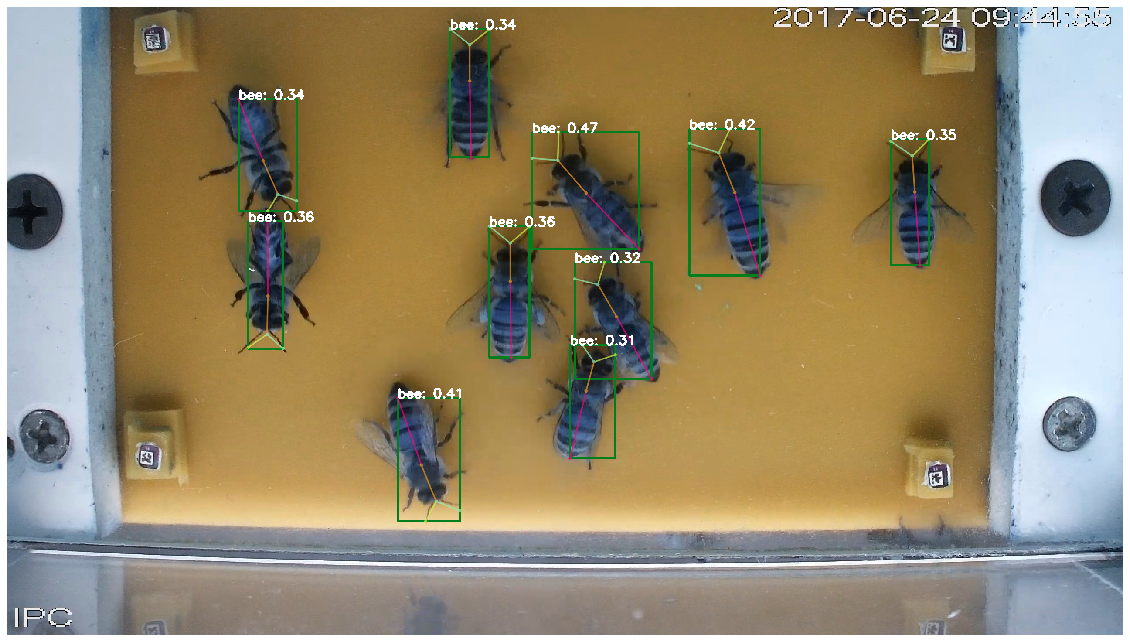

In [15]:
#single mse dp
import matplotlib.gridspec as gridspec
from itertools import chain

pad = 5
k=10
#print("test ig: ", test_images)
#print("test files: ", test_image_files)
rows = ["Heatmap Loss", "Original DP Loss", "Combo Loss", "Combo OG"]
cols = ["HM Markers", "DP Marker", "DP Boxes"]
data_size = "250"
version = "0"
loss = "standard_small_lr_f90_2dl/0"
#loss = "standard_small_lr_f90/0"


config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                     'DATATYPE', 'bee', \
                     'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                     'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_0001000.pth',\
                     'DATASETS.TEST', "('bee_val_cocostyle',)",\
                     'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                    ])

coco_demo = COCODemo(
            cfg,
            min_image_size=800,
            confidence_threshold=0.2,
)


mse_total = []
tim = [test_images[0]]
for idx, image in enumerate(test_images):
    mse_per_bee = []
    predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
    kps = tps.get_field("keypoints").keypoints
    bboxes = tps.bbox
    print("BBOXES", bboxes)
    print("KPS",kps)
    plt.gca().invert_yaxis()
    imshow(predictions[:, :, [2, 1, 0]])
    plt.gca().invert_yaxis()
    
    for p in data_an['images'][:]:
        if (str(p['file_name']) == test_files[idx] ):
            im_id = p['id']         
    print(im_id)
    for p in data_an['annotations'][:]:
        if ((p['image_id']) == im_id ):
            #print(p['id'])
            #bb = p["segmentation"]#p['bbox']
            bb = p['bbox']
            #bb = bb[0]
            print('bb', bb)
            bb_f = [bb[:2], bb[2:4], bb[4:6], bb[6:]]
            print('bbf', bb_f)
            bbox = bounding_box(bb_f)
            cent_val = get_centroid(bbox)
            dists = []
            #print(cent_val)
            for index, p_bbox in enumerate(bboxes):
                cp = get_centroid(p_bbox)
                dist = get_dist(cent_val, cp)
                dists.append(dist)
                #print(dist)
            min_idx = dists.index(min(dists))
            #print("min id", min_idx)
            kps_val = p["keypoints"]
            print('kps val', kps_val)
            # comment for test and remove og
            #kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
            #print('kps val', kps_val)
            kps_pred = kps[min_idx].tolist()
            kps_pred_list = [kps_pred[0][:2],kps_pred[1][:2],kps_pred[2][:2],kps_pred[3][:2],kps_pred[4][:2]]
            kps_pl = list(chain.from_iterable(kps_pred_list))
            print("kps val", kps_pred)
            print("kp pred listt", kps_pred_list)
            diff_vec = np.array(kps_val) - np.array(kps_pl)
            #print(diff_vec)
            #print(diff_vec*diff_vec)
            diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
            #print(diff_vec_sum_sq)
            mse_per_bee.append(diff_vec_sum_sq)
        
    mse_per_image = sum(mse_per_bee)
    #print("mse", mse_per_image)
    #print("mse", mse_per_bee)
    mse_final = mse_per_image/len(mse_per_bee)
    mse_total.append(mse_final)
    #print("mse final", mse_final)
 

    #img3 = predictions[:, :, [2, 1, 0]]
    #b,g,r = cv2.split(img3)       # get b,g,r
    #img3 = cv2.merge([r,g,b])     # switch it to rgb
    #im = axes[idx][2].imshow(img3)
    #axes[idx][2].invert_yaxis()
    #plt.savefig(base_file + '_reg.png')
print("mse total for all images", mse_total)
print(sum(mse_total))
mse_test = sum(mse_total)/len(mse_total)
print("mse yo", mse_test)


li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b2169b064a8>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
t f:  <class 'tuple'>
dim f[0]:  torch.Size([1, 256, 100, 180])
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=17, image_width=2560, image_height=1440, mode=xyxy)
51501
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b20e4fd62e8>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
t f:  <class 'tuple'>
dim f[0]:  torch.Size([1, 256, 100, 180])
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
raw re

now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
t f:  <class 'tuple'>
dim f[0]:  torch.Size([1, 256, 100, 180])
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=13, image_width=2560, image_height=1440, mode=xyxy)
52587
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b216e872828>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
t f:  <class 'tuple'>
dim f[0]:  torch.Size([1, 256, 100, 180])
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:


53857
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b2161d99c18>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
t f:  <class 'tuple'>
dim f[0]:  torch.Size([1, 256, 100, 180])
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T
raw res:
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
FIELDS:
predictions BoxList(num_boxes=100, image_width=2560, image_height=1440, mode=xyxy)
top preds BoxList(num_boxes=15, image_width=2560, image_height=1440, mode=xyxy)
53866
li:  <maskrcnn_benchmark.structures.image_list.ImageList object at 0x2b2161e88710>
now prop
TARGETS:  None
feats:  5
feats:  1
feats:  256
t f:  <class 'tuple'>
dim f[0]:  torch.Size([1, 256, 100, 180])
props grcnn
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
[BoxList(num_boxes=100, image_width=1422, image_height=800, mode=xyxy)]
None
R
T


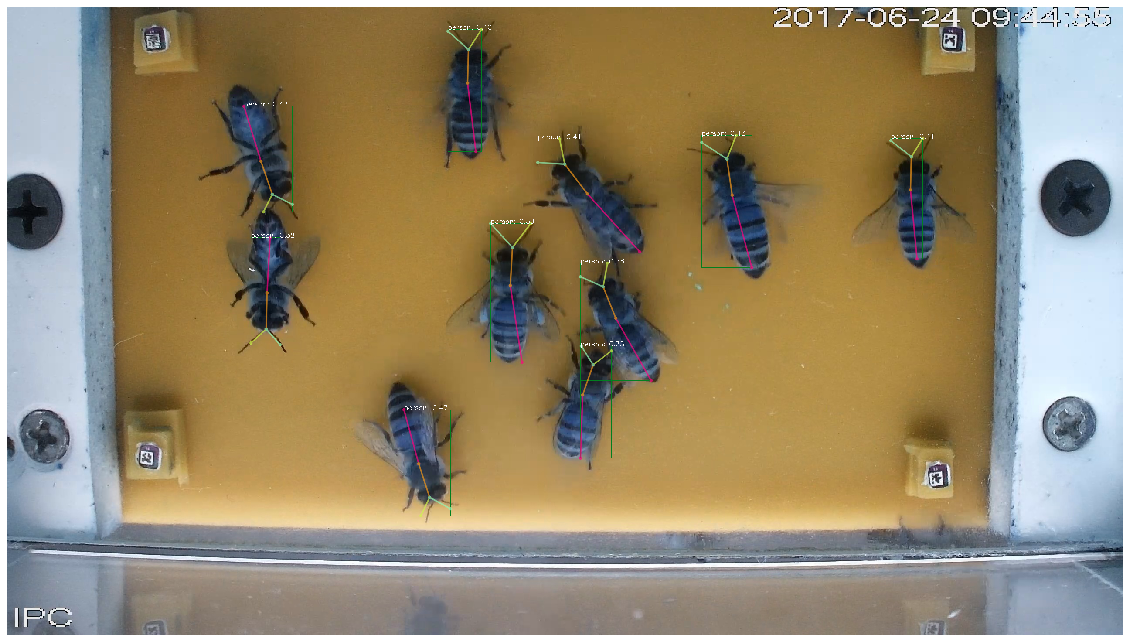

In [61]:
#The new losses

pad = 5
k=10
#print("test ig: ", test_images)
#print("test files: ", test_image_files)
rows = ["Heatmap Loss", "Original DP Loss", "Combo Loss", "Combo OG"]#"DP Predictions", "Combined Heatmap", "Combined Pred"]
cols = ["HM Markers", "DP Marker", "DP Boxes"]
data_size = "250"
versions = ["1"]#, "5", "6", "7"]#, "8", "9", "a", "b", "c", "d", "e", "f", "g", "h", "k", "m", "n", "p", "q"]#["0", "1", "2", "3"]
#loss = "combined_from_standard_nw"
#losses = ["combined_fs_nw_", "combined_fs_w_", "combined_fs_nw_avg", "combined_fs_w_avg"]
#losses = ["combined_fs_fw_vo"]#,"combined_fs_fc_un"]
#losses = ["combined_fsla_v2"]
losses = ["combined_fs_dl_test_v2", "combined_fs_dl_test_v2", "combined_fs_dl_test_v2", "combined_fs_dl_test_v2"]
#losses = ["combined_fs_wsamp_95"]#["combined_fs_test_dl"]#["combined_fs25k_v1"]
alphas = [".001"]#, ".001", ".1"]#, ".01", ".1"]#, ".5"]#, "1"]

test_losses = []

for (loss,version) in zip(losses,versions):
    for alpha in alphas:
        config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

        cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
        cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                             'DATATYPE', 'bee', \
                             'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss + '/'+ version + '/'+ alpha +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                             'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/'+ version + '/'+ alpha +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_0002500.pth',\
                             'DATASETS.TEST', "('bee_val_cocostyle',)",\
                             'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                            ])

        coco_demo = COCODemo(
                    cfg,
                    min_image_size=800,
                    confidence_threshold=0.2,
        )


        plt.figure(figsize = (20,12))

        mse_total = []
        for idx, image in enumerate(test_images):
            mse_per_bee = []
            predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
            kps = tps.get_field("keypoints").keypoints
            bboxes = tps.bbox
            #print(bbox)
            #print(kps)
            plt.gca().invert_yaxis()
            imshow(predictions[:, :, [2, 1, 0]])
            plt.gca().invert_yaxis()

            for p in data_an['images'][:]:
                if (str(p['file_name']) == test_files[idx] ):
                    im_id = p['id']         
            print(im_id)
            for p in data_an['annotations'][:]:
                if ((p['image_id']) == im_id ):
                    #print(p['id'])
                    #bb = p["segmentation"]#p['bbox']
                    bb = p['bbox']
                    #bb = bb[0] #comment line for test
                    bb_f = [bb[:2], bb[2:4], bb[4:6], bb[6:]]
                    bbox = bounding_box(bb_f)
                    cent_val = get_centroid(bbox)
                    dists = []
                    #print(cent_val)
                    for index, p_bbox in enumerate(bboxes):
                        cp = get_centroid(p_bbox)
                        dist = get_dist(cent_val, cp)
                        dists.append(dist)
                        #print(dist)
                    min_idx = dists.index(min(dists))
                    #print("min id", min_idx)
                    kps_val = p["keypoints"]
                   # print('kps pre del', kps_valog)
                    #comment this line for test set
                    #kps_val = [x for i, x in enumerate(kps_valog) if (i+1)%3 !=0]
                    #kps_val = kps_val[!(2::3)] 
                    kps_pred = kps[min_idx].tolist()
                    kps_pred_list = [kps_pred[0][:2],kps_pred[1][:2],kps_pred[2][:2],kps_pred[3][:2],kps_pred[4][:2]]
                    kps_pl = list(chain.from_iterable(kps_pred_list))
                    #print("kps val", kps_val)
                    #print("kp pred", kps_pl)
                    diff_vec = np.array(kps_val) - np.array(kps_pl)
                    #print(diff_vec)
                    #print(diff_vec*diff_vec)
                    diff_vec_sum_sq = np.sum(diff_vec*diff_vec)
                    #print(diff_vec_sum_sq)
                    mse_per_bee.append(diff_vec_sum_sq)

            mse_per_image = sum(mse_per_bee)
            #print("mse", mse_per_image)
            #print("mse", mse_per_bee)
            mse_final = mse_per_image/len(mse_per_bee)
            mse_total.append(mse_final)
            #print("mse final", mse_final)


            #img3 = predictions[:, :, [2, 1, 0]]
            #b,g,r = cv2.split(img3)       # get b,g,r
            #img3 = cv2.merge([r,g,b])     # switch it to rgb
            #im = axes[idx][2].imshow(img3)
            #axes[idx][2].invert_yaxis()
            #plt.savefig(base_file + '_reg.png')
        #print("mse total for all images", mse_total)
        #print(sum(mse_total))
        mse_test = sum(mse_total)/len(mse_total)
        test_losses.append({loss+'/'+version+'/'+alpha : mse_test})
        #print("mse "+loss, mse_test)
        
print(test_losses)

In [ ]:
#big plot
import matplotlib.gridspec as gridspec

pad = 5
k=10
#print("test ig: ", test_images)
#print("test files: ", test_image_files)
rows = ["Heatmap Loss", "Original DP Loss", "Combo Loss", "Combo OG"]#"DP Predictions", "Combined Heatmap", "Combined Pred"]
cols = ["HM Markers", "DP Marker", "DP Boxes"]
data_size = "250"
version = "0"
#loss = "combined_from_standard_nw"
loss = "combined_fs_w_/.001"


config_file = "/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml"

cfg.merge_from_file("/home/bsb2144/directpose/configs/fcos/fcos_kps_ms_training_R_50_FPN_1x.yaml")
cfg.merge_from_list(['DATALOADER.NUM_WORKERS', '2', \
                     'DATATYPE', 'bee', \
                     'OUTPUT_DIR', 'training_dir/' + data_size + '/' + loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee1', \
                     'MODEL.WEIGHT', '/home/bsb2144/directpose/tools/training_dir/' + data_size + '/'+ loss +'/fcos_kps_ms_training_R_50_FPN_1x_bee/model_0002500.pth',\
                     'DATASETS.TEST', "('bee_val_cocostyle',)",\
                     'DATASETS.TRAIN', "('bee_train_cocostyle', )",\
                    ])

coco_demo = COCODemo(
            cfg,
            min_image_size=800,
            confidence_threshold=0.2,
)

plt.figure(figsize = (20,12))


for idx, image in enumerate(test_images):
    predictions, tps, hm_res, stride, hms, targets, c_loss = coco_demo.run_on_opencv_image(image)
    kps = tps.get_field("keypoints").keypoints
    bbox = tps.bbox
    print(bbox)
    print(kps)
    plt.gca().invert_yaxis()
    imshow(predictions[:, :, [2, 1, 0]])
    plt.gca().invert_yaxis()
    